In [1]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0

In [2]:
mesh = fn.Mesh('geometry/geo_charge.xml')
subdomains = fn.MeshFunction("size_t", mesh, 'geometry/geo_charge_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'geometry/geo_charge_facet_region.xml')

In [3]:
dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
V0 = fn.FunctionSpace(mesh, 'DG', 0)
V = fn.FunctionSpace(mesh, 'P', 2)

In [4]:
outer_boundary = fn.DirichletBC(V, fn.Constant(0), boundaries, 4)
bcs =[outer_boundary]

In [5]:
Q = 50
sigma = 1

class rho(fn.UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        values[0] = Q/(2*np.pi * sigma**2) * np.exp(-(x[0]**2 + x[1]**2)/2/sigma**2)
        return 0

# This function is discontinuous as r = 1
# 
#    def eval_cell(self, values, x, cell):
#       if self.markers[cell.index] == 1:
#            values[0] = Q/(2*np.pi * sigma**2) * np.exp(-(x[0]**2 + x[1]**2)/2/sigma**2)
#       else:
#            values[0] = 0
#        return 0
        

charge_density = rho(subdomains, degree=2)

In [6]:
# This is an alternative to making an expression

#rho = fn.Function(V0)
#
#for n, cell_no in enumerate(subdomains.array()):
#    subdomain_no = subdomains.array()[n]
#    if subdomain_no == 1:
#        value = 5
#    if subdomain_no == 2:
#        value = 0
#        
#    rho.vector()[n] = value

## Plot the charge density

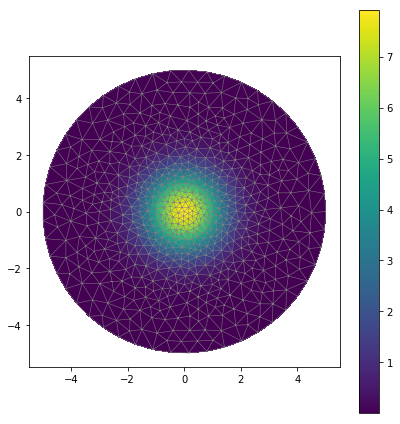

In [7]:
plt.figure(figsize=(6,6))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(fn.project(charge_density, V0))
plt.colorbar(p)
plt.tight_layout()
#plt.savefig('images/charge_density.png', bbox_inches='tight')
plt.show()

## Solve the problem

In [8]:
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
a = fn.dot(fn.grad(u), fn.grad(v)) * epsilon_0 * fn.dx
L = charge_density * v * fn.dx
u = fn.Function(V)
fn.solve(a == L, u, bcs)

## Plot the electric potential distribution

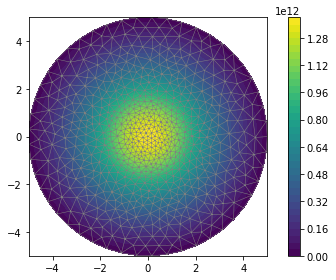

In [9]:
%matplotlib inline
plt.figure()
fn.plot(mesh, linewidth=0.5)
p = fn.plot(u)
plt.colorbar(p)
plt.tight_layout()
#plt.savefig('images/electric_potential.png', bbox_inches='tight')
plt.show()

## Calculate and plot the electric field

In [10]:
electric_field = fn.project(-fn.grad(u))

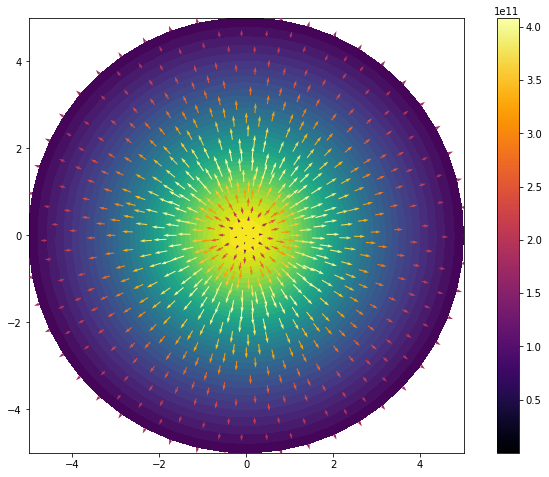

In [11]:
%matplotlib inline
plt.figure(figsize=(12,8))
# fn.plot(mesh, linewidth=0.5)
fn.plot(u)
p = fn.plot(electric_field, zorder=3, cmap='inferno')
plt.colorbar(p)
#plt.savefig('images/electric_field.png', bbox_inches='tight')
plt.show()

## Evaluate the electric field along a line
plot the potential distribution with the line overlaid

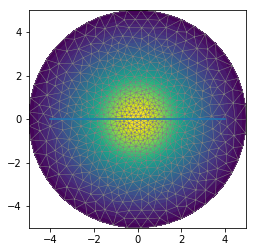

In [12]:
x = np.linspace(-4, 4, 1000)
yc = np.zeros(len(x))

u_1 = np.array(list(map(u, zip(x, yc))))
e_field = np.array(list(map(electric_field, zip(x, yc))))

%matplotlib inline
plt.figure()
fn.plot(mesh, linewidth=0.5)
fn.plot(u)
plt.plot(x, yc)
plt.show()

## Plot the FEniCS solution overlaid with the analytical solution

In [13]:
def E_u(r, a, j):
    outside = np.abs(r) > a
    inside = np.logical_not(outside)
    b = np.zeros(len(r))
    b[inside] = rho * r[inside] / 2 / epsilon_0
    b[outside] = rho * a**2 / 2 / r[outside] / epsilon_0
    return b

def E(r):
    E = Q * (1-np.exp(-r**2/sigma**2/2)) / (2*np.pi*r) / epsilon_0
    return E

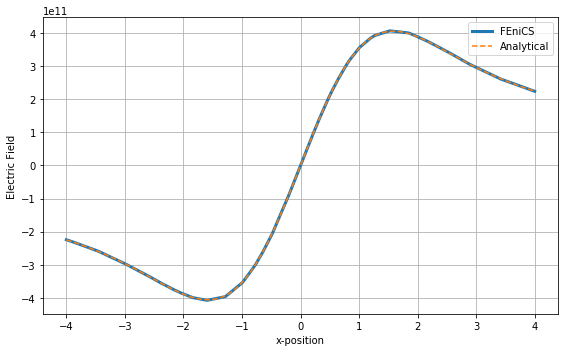

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(x, e_field[:, 0], linewidth=3, label='FEniCS')
plt.plot(x, E(x), 'C1--', label='Analytical')
plt.xlabel("x-position")
plt.ylabel("Electric Field")
plt.grid()
plt.tight_layout()
plt.legend(loc=0)
#plt.savefig('images/electric_field_comp.png', bbox_inches='tight')
plt.show()

## Plot the percentage difference

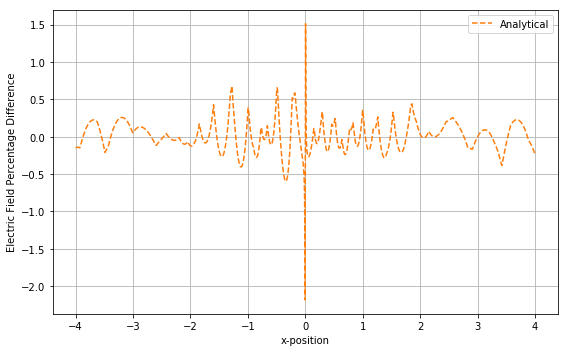

In [15]:
percentage_difference = (e_field[:, 0]-E(x)) / E(x) * 100

plt.figure(figsize=(8, 5))
plt.plot(x, percentage_difference, 'C1--', label='Analytical')
plt.xlabel("x-position")
plt.ylabel("Electric Field Percentage Difference")
plt.grid()
plt.tight_layout()
plt.legend(loc=0)
#plt.savefig('images/electric_field_difference.png', bbox_inches='tight')
plt.show()

## Output to file

In [16]:
potentialFile = fn.File('output/potential.pvd')
potentialFile << u

vtkfile = fn.File('output/e_field.pvd')
vtkfile << electric_field